### End-to-end SSL stepcounter training with OxWalk

This notebook trains the stepcounter that was used in:

Small SR, Chan S, Walmsley R, et al. (2023)
[Development and Validation of a Machine Learning Wrist-worn Step Detection Algorithm with Deployment in the UK Biobank](https://www.medrxiv.org/content/10.1101/2023.02.20.23285750v1).
medRxiv. DOI: 10.1101/2023.02.20.23285750

This notebook has been modified to run on Dr. Keadle's Cal Poly ACT24 data.

Original notebook can be found [here](https://github.com/OxWearables/stepcount/blob/main/train-ssl.ipynb).

## Imports

In [1]:
import re
import glob
import os
import numpy as np
import pandas as pd
import pathlib
import torch
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed

Check torch version and to see if GPU acceleration is available.

This notebook was originally run on torch version 2.2.2+cu121, with GPU acceleration.

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

2.2.2+cu121
True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Data processing

Below are functions to load the data, adapted from the original functions provided by UK Biobank. Requires the following files:
- ACT24_Apr2024 directory, with ACT24_###_#_SSL.csv files created by the DATA 2024 team. ### is the id, # is the observation.

In [3]:
DATA_DIR = 'ACT24_Apr2024'  # location of data (the ACT24_###_#_SSL.csv files should be in this folder)
DATAFILES = os.path.join(DATA_DIR, 'ACT24_*.csv')
OUT_DIR = './data/act24_80hz_2/'  # output location of the processed dataset
WINDOW_SEC = 10  # seconds
STEP_THRESHOLD = 4  # how many steps per window to consider a step (equal or more) 

DEVICE_HZ = 80  # original sample rate Hz
RESAMPLE_HZ = 30  # Hz
WINDOW_OVERLAP_SEC = 0  # seconds
WINDOW_LEN = int(DEVICE_HZ * WINDOW_SEC)  # device ticks
WINDOW_OVERLAP_LEN = int(DEVICE_HZ * WINDOW_OVERLAP_SEC)  # device ticks
WINDOW_STEP_LEN = WINDOW_LEN - WINDOW_OVERLAP_LEN  # device ticks
WINDOW_TOL = 0.01  # 1%


def resize(x, length, axis=1):
    """Resize the temporal length using linear interpolation.
    X must be of shape (N,M,C) (channels last) or (N,C,M) (channels first),
    where N is the batch size, M is the temporal length, and C is the number
    of channels.
    If X is channels-last, use axis=1 (default).
    If X is channels-first, use axis=2.
    """
    from scipy.interpolate import interp1d

    length_orig = x.shape[axis]
    t_orig = np.linspace(0, 1, length_orig, endpoint=True)
    t_new = np.linspace(0, 1, length, endpoint=True)
    x = interp1d(t_orig, x, kind="linear", axis=axis, assume_sorted=True)(
        t_new
    )
    return x


def is_good_quality(w):
    """ Window quality check """

    if w.isna().any().any():
        return False

    if len(w) != WINDOW_LEN:
        return False

    w_start, w_end = w.index[0], w.index[-1]
    w_duration = w_end - w_start
    target_duration = pd.Timedelta(WINDOW_SEC, 's')
    if np.abs(w_duration - target_duration) > WINDOW_TOL * target_duration:
        return False

    return True


def make(datafile):
    X, Y, T, P, = [], [], [], []
    y_step = []
    Y_all = []

    data = pd.read_csv(datafile, parse_dates=['timestamp'], index_col='timestamp')

    p = re.search(r'(ACT24_\d{3}_\d{1})', datafile, flags=re.IGNORECASE).group()

    for i in range(0, len(data), WINDOW_STEP_LEN):
        w = data.iloc[i:i + WINDOW_LEN]
        postures = w['posture'].mode()

        if not is_good_quality(w) or "private/not coded" in list(postures):
            continue

        t = w.index[0].to_datetime64()
        x = w[['x', 'y', 'z']].values
        count = int(w['step'].sum())
        posture = postures.sample(n=1).iloc[0]

        if count >= STEP_THRESHOLD:
            y = 'walk'
        else:
            y = 'notwalk'
            
        y_all = posture

        X.append(x)
        Y.append(y)
        T.append(t)
        P.append(p)
        y_step.append(count)
        Y_all.append(y_all)

    X = np.asarray(X)
    Y = np.asarray(Y)
    T = np.asarray(T)
    P = np.asarray(P)
    y_step = np.asarray(y_step)
    y_all = np.asarray(Y_all)

    if DEVICE_HZ != RESAMPLE_HZ:
        X = resize(X, int(RESAMPLE_HZ * WINDOW_SEC))

    return X, Y, T, P, y_step, y_all

Convert the raw data into 10s windowed data X at 30Hz, with step count annotations Y_step and group labels groups. A categorical array Y is also generated. Save to disk for later reuse. **This means that the code in this section only needs to be run once!**

In [5]:
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

with Parallel(n_jobs=4, prefer="threads") as parallel:
    results = parallel(delayed(make)(datafile) for datafile in tqdm(glob.glob(DATAFILES)))

x, y, t, p, y_step, y_all = zip(*results)

X = np.vstack(x)  # data windows
Y = np.hstack(y)  # binary labels walk/notwalk (based on Y_step >= STEP_THRESHOLD)
Y_step = np.hstack(y_step)  # step counts per window
T = np.hstack(t)  # timestamps
groups = np.hstack(p)  # group ids
Y_all = np.hstack(y_all)

np.save(os.path.join(OUT_DIR, 'X'), X)
np.save(os.path.join(OUT_DIR, 'Y'), Y)
np.save(os.path.join(OUT_DIR, 'time'), T)
np.save(os.path.join(OUT_DIR, 'groups'), groups)
np.save(os.path.join(OUT_DIR, 'Y_step'), Y_step)
np.save(os.path.join(OUT_DIR, 'Y_all'), Y_all)

print(f"Saved in {OUT_DIR}")
print("X shape:", X.shape)
print("Y distribution:")
print(pd.Series(Y).value_counts())

100%|██████████| 32/32 [01:42<00:00,  3.19s/it]


Saved in ./data/act24_80hz_2/
X shape: (32640, 300, 3)
Y distribution:
notwalk    25728
walk        6912
Name: count, dtype: int64


## Load data from disk

The oxwearables activity classifier can only use numeric input, so below we create mappings to convert the posture categorical labels to numbers and back.

In [3]:
posture_to_num = {"notwalk": 0, "walk": 1}
num_to_posture = {0: "notwalk", 1: "walk"}

Load data from disk. This is what was saved in the previous section. Note that the postures have been converted to numbers.

In [4]:
path = './data/act24_80hz_2/'

X = np.load(path + 'X.npy')
Y_step = np.load(path + 'Y_step.npy')
Y = pd.Series(np.load(path + 'Y.npy')).map(posture_to_num)
groups = np.load(path + 'groups.npy')
T = np.load(path + 'time.npy')

In [5]:
pd.Series(Y).value_counts(normalize=True)

0    0.788235
1    0.211765
Name: proportion, dtype: float64

## Posture classifier NN code

Below is the neural network that classifies posture, modified to classify more postures as they appear in the ACT24 dataset.

The stepcount dependencies can be downloaded here, if there are any errors in loading the package with pip:
- <https://github.com/OxWearables/stepcount/tree/main/src/stepcount>

In [6]:
import torch
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn.model_selection import GroupShuffleSplit
from stepcount2 import hmm_utils
from stepcount2 import sslmodel
from torch.utils.data import DataLoader

from collections import Counter

class WalkDetectorSSL:
    def __init__(
            self,
            device='cpu',
            batch_size=100,
            weights_path='state_dict.pt',
            repo_tag='v1.0.0',
            hmm_params=None,
            verbose=False,
    ):
        self.device = device
        self.weights_path = weights_path
        self.repo_tag = repo_tag
        self.batch_size = batch_size
        self.state_dict = None

        self.verbose = verbose

        hmm_params = hmm_params or dict()
        self.hmms = hmm_utils.HMMSmoother(**hmm_params)

    def fit(self, X, Y, groups=None):
        sslmodel.verbose = self.verbose

        if self.verbose:
            print('Training SSL')

        # prepare training and validation sets
        folds = GroupShuffleSplit(
            1, test_size=0.2, random_state=41
        ).split(X, Y, groups=groups)
        train_idx, val_idx = next(folds)

        x_train = X[train_idx]
        x_val = X[val_idx]

        y_train = np.array(Y[train_idx])
        y_val = np.array(Y[val_idx])

        group_train = np.array(groups[train_idx])
        group_val = np.array(groups[val_idx])

        train_dataset = sslmodel.NormalDataset(x_train, y_train, pid=group_train, name="training", augmentation=True)
        val_dataset = sslmodel.NormalDataset(x_val, y_val, pid=group_val, name="validation")

        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=1,
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=1,
        )

        # balancing to 90% notwalk, 10% walk
        c = Counter(y_train)
        notwalk = c[0]
        walk = c[1]
        class_weights = [(walk * 9.0) / notwalk, 1.0]

        model = sslmodel.get_sslnet(tag=self.repo_tag, pretrained=True)
        model.to(self.device)

        sslmodel.train(model, train_loader, val_loader, self.device, class_weights, weights_path=self.weights_path)
        model.load_state_dict(torch.load(self.weights_path, self.device))

        if self.verbose:
            print('Training HMM')

        # train HMM with predictions of the validation set
        y_val, y_val_pred, group_val = sslmodel.predict(model, val_loader, self.device, output_logits=True)
        y_val_pred_sf = softmax(y_val_pred, axis=1)

        self.hmms.fit(y_val_pred_sf, y_val, groups=group_val)

        # move model to cpu to get a device-less state dict (prevents device conflicts when loading on cpu/gpu later)
        model.to('cpu')
        self.state_dict = model.state_dict()

        return self

    def predict(self, X, groups=None):
        sslmodel.verbose = self.verbose

        dataset = sslmodel.NormalDataset(X, name='prediction')
        dataloader = DataLoader(
            dataset,
            batch_size=512,
            shuffle=False,
            num_workers=0,
        )

        model = sslmodel.get_sslnet(tag=self.repo_tag, pretrained=False)
        model.load_state_dict(self.state_dict)
        model.to(self.device)

        _, y_pred, _ = sslmodel.predict(model, dataloader, self.device, output_logits=False)

        y_pred = self.hmms.predict(y_pred, groups=groups)

        return y_pred

## Train posture classifier

The code below will save the model to the disk. **Don't run more than once!**

In [8]:
wd = WalkDetectorSSL(
    device='cuda' if torch.cuda.is_available() else 'cpu',
    batch_size=512,
    verbose=True
)
wd.fit(X, Y, groups)
joblib.dump(wd, 'keadle1.joblib.lzma', compress=('lzma', 3))

Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount2\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Validation loss decreased (inf --> 0.672869). Saving model ...
[  0/100] | train_loss: 1.449 | train_acc: 0.841 | val_loss: 0.673 | val_acc: 0.87


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


Validation loss decreased (0.672869 --> 0.320499). Saving model ...
[  1/100] | train_loss: 0.285 | train_acc: 0.874 | val_loss: 0.320 | val_acc: 0.88


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


Validation loss decreased (0.320499 --> 0.269737). Saving model ...
[  2/100] | train_loss: 0.206 | train_acc: 0.886 | val_loss: 0.270 | val_acc: 0.88


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


Validation loss decreased (0.269737 --> 0.264872). Saving model ...
[  3/100] | train_loss: 0.164 | train_acc: 0.897 | val_loss: 0.265 | val_acc: 0.88


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


Validation loss decreased (0.264872 --> 0.259014). Saving model ...
[  4/100] | train_loss: 0.152 | train_acc: 0.903 | val_loss: 0.259 | val_acc: 0.88


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


EarlyStopping counter: 1/5
[  5/100] | train_loss: 0.138 | train_acc: 0.910 | val_loss: 0.266 | val_acc: 0.88


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


EarlyStopping counter: 2/5
[  6/100] | train_loss: 0.130 | train_acc: 0.918 | val_loss: 0.300 | val_acc: 0.87


100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


EarlyStopping counter: 3/5
[  7/100] | train_loss: 0.115 | train_acc: 0.928 | val_loss: 0.265 | val_acc: 0.89


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


EarlyStopping counter: 4/5
[  8/100] | train_loss: 0.105 | train_acc: 0.934 | val_loss: 0.289 | val_acc: 0.88


100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


EarlyStopping counter: 5/5
[  9/100] | train_loss: 0.095 | train_acc: 0.941 | val_loss: 0.330 | val_acc: 0.88
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


['keadle1.joblib.lzma']

Predict postures

In [ ]:
wd = joblib.load('keadle1.joblib.lzma')

In [9]:
Y_hat = wd.predict(X, groups)

Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount2\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 64/64 [00:07<00:00,  8.86it/s]


Observed posture distribution:

In [10]:
obs = pd.Series(Y).map(num_to_posture)
obs.value_counts()

notwalk    25728
walk        6912
Name: count, dtype: int64

Predicted posture distribution:

In [11]:
pred = pd.Series(Y_hat).map(num_to_posture)
pred.value_counts()

notwalk    27406
walk        5234
Name: count, dtype: int64

In [12]:
results = pd.concat([obs.value_counts(), pred.value_counts()], axis=1).fillna(0).astype(int)
results.columns = ["obs", "pred"]
results["error"] = np.abs(results["obs"] - results["pred"])
results["perror"] = np.round(results["error"] / results["obs"], 4) * 100
results

,obs,pred,error,perror
notwalk,25728,27406,1678,6.52
walk,6912,5234,1678,24.28


Posture classifier confusion matrix:

In [13]:
Y_cat = np.unique(np.load(path+'Y.npy'))

In [14]:
conf = pd.crosstab(pd.Categorical(obs, categories=Y_cat), pd.Categorical(pred, categories=Y_cat), dropna=False)
conf.index.name = "obs"
conf.columns.name = "pred"
conf

pred,notwalk,walk
obs,,
notwalk,25070,658
walk,2336,4576


Posture classifier accuracy:

In [15]:
accuracy = np.diag(conf).sum() / conf.sum().sum()
accuracy

0.9082720588235295

Posture classifier recall by posture:

In [16]:
recall = np.diag(conf) / conf.sum(axis=1)
recall

obs
notwalk    0.974425
walk       0.662037
dtype: float64

Posture classifier precision by posture:

In [17]:
precision = np.diag(conf) / conf.sum(axis=0)
precision

pred
notwalk    0.914763
walk       0.874284
dtype: float64

Posture classifier F1 score by posture:

In [18]:
f1 = 2 * precision * recall / (precision + recall)
f1

pred
notwalk    0.943652
walk       0.753499
dtype: float64

## Tune step counter

Uses peak detection scipy algorithm to count steps. The distance and prominence are tuned to minimize mean absolute error (MAE) in steps. This is a modified version of the `.fit()` method for the StepCount object in the stepcount package.

Again, the stepcount dependencies can be downloaded manually from here in case of difficulties loading the package from pip:
- <https://github.com/OxWearables/stepcount/tree/main/src/stepcount>

In [19]:
from stepcount.models import toV, calc_sample_weight, batch_count_peaks_from_V, get_cv_scores
from sklearn import metrics
from scipy.optimize import minimize

In [20]:
steptol = 4
sample_rate = 30
lowpass_hz = 5
pnr = 1.0

Yp = np.zeros_like(Y)
W = np.zeros_like(Y_step)
W[Y_step >= steptol] = 1
Y_step_cp = Y_step.copy()
Y_step_cp[Y_step < steptol] = 0

whr_walk_pred = (Y_hat == 1)

# train step counter
Xw, Yw = X[whr_walk_pred], Y_step_cp[whr_walk_pred]
Vw = toV(Xw, sample_rate, lowpass_hz)

sample_weight = calc_sample_weight(W, pnr)
sample_weight_w = sample_weight[whr_walk_pred]

def mae(x):
    Ywp = batch_count_peaks_from_V(Vw, sample_rate, to_params(x))
    err = metrics.mean_absolute_error(Yw, Ywp, sample_weight=sample_weight_w)
    return err

def to_params(x):
    params = {
        "distance": x[0],
        "prominence": x[1],
    }
    return params

def mae(x):
    Ywp = batch_count_peaks_from_V(Vw, sample_rate, to_params(x))
    err = metrics.mean_absolute_error(Yw, Ywp, sample_weight=sample_weight_w)
    return err

res = minimize(
    mae,
    x0=[.5, .5],
    bounds=[
        (.2, 2),  # 0.2s to 2s (4Hz - 0.5Hz)
        (.15, 1),  # 0.15g to 1g
    ],
    method='Nelder-Mead'
)

find_peaks_params = to_params(res.x)

Yp[whr_walk_pred] = batch_count_peaks_from_V(Vw, sample_rate, find_peaks_params)

Distance and prominence for the peak detector for each category:

In [21]:
find_peaks_params

{'distance': 0.3546875000000047, 'prominence': 0.15}

Predicted step count overall:

In [22]:
Yp.sum()

70297

Observed step count overall:

In [23]:
Y_step.sum()

89248

Error between predicted and observed step counts, by each id/obs:

In [24]:
preds = pd.concat([pd.Series(groups), pd.Series(Y_step), pd.Series(Yp)], axis=1)
results = preds.groupby(0).sum()
results['error'] = results[1] - results[2]
results['abs_per_error'] = results['error'].abs() / results[1]
results

,1,2,error,abs_per_error
0,,,,
ACT24_116_1,4492,3757,735,0.163624
ACT24_116_2,443,309,134,0.302483
ACT24_117_1,5808,5405,403,0.069387
ACT24_117_2,3065,3030,35,0.011419
ACT24_122_1,319,263,56,0.175549
ACT24_122_2,10909,9803,1106,0.101384
ACT24_124_1,2676,1895,781,0.291854
ACT24_124_2,1879,1601,278,0.147951
ACT24_126_2,1446,1348,98,0.067773


Cumulative step plots for each id/obs:

In [25]:
import matplotlib.pyplot as plt

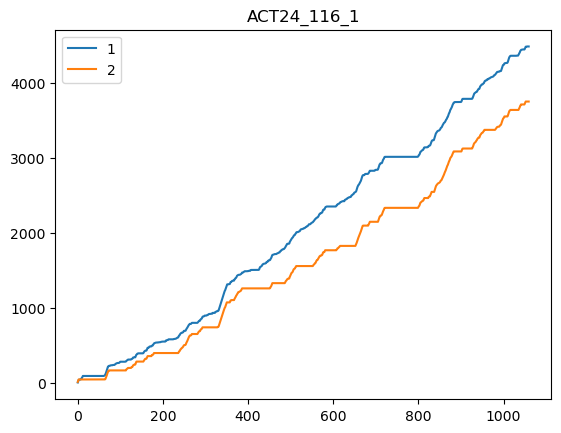

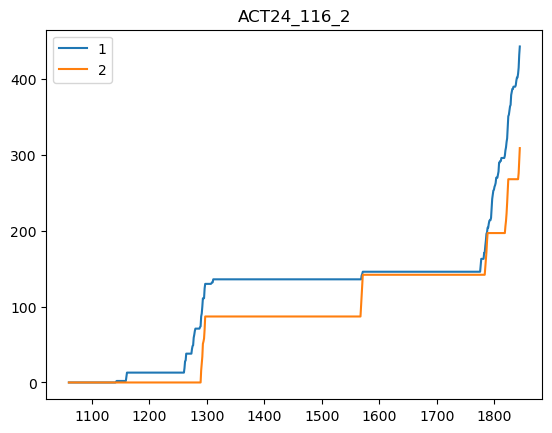

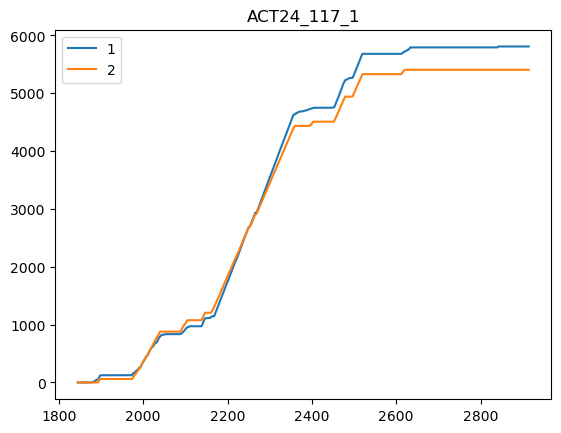

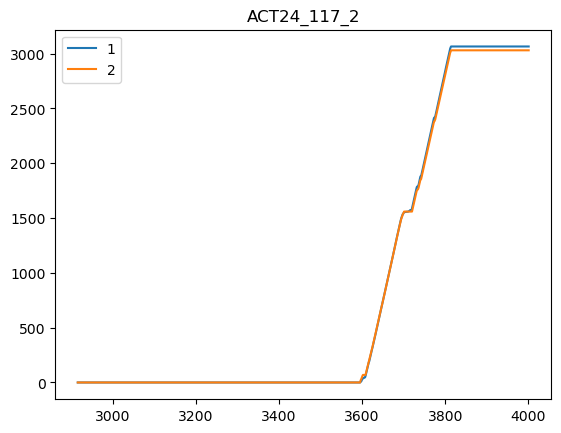

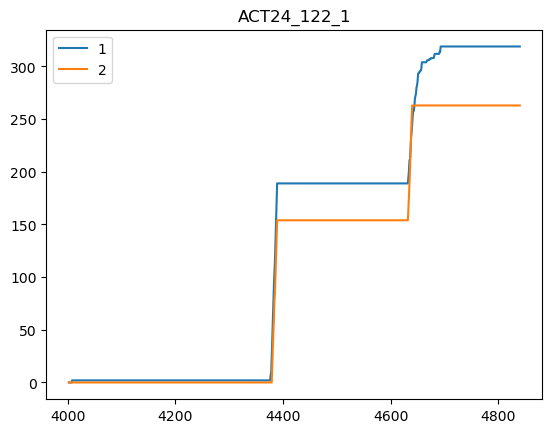

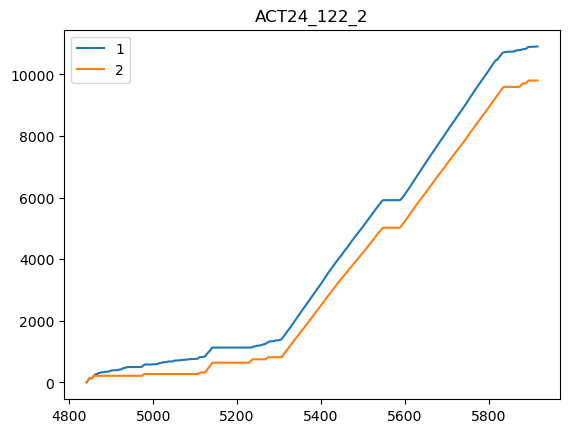

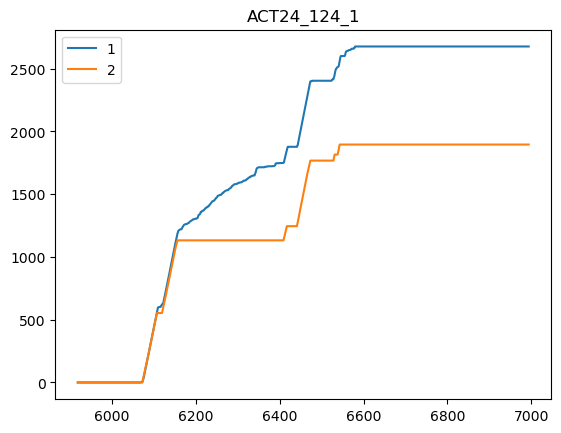

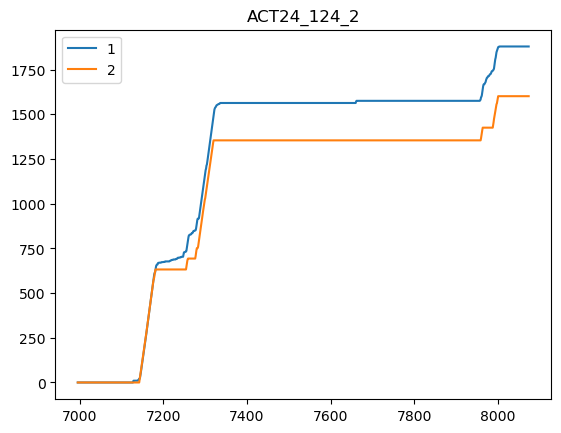

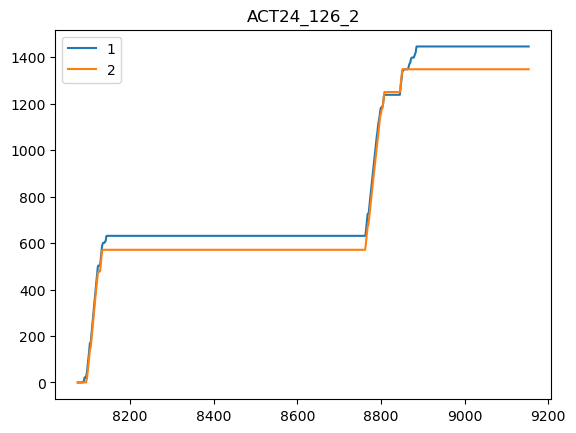

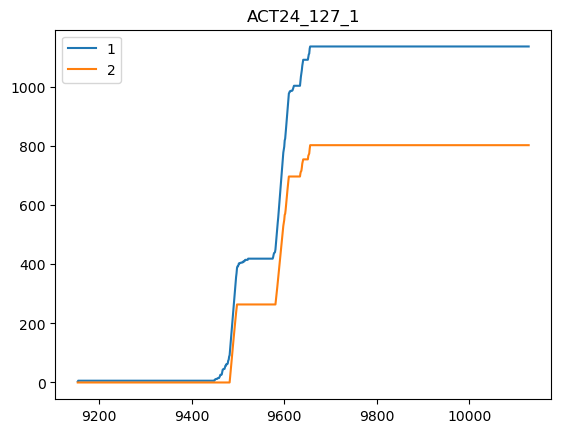

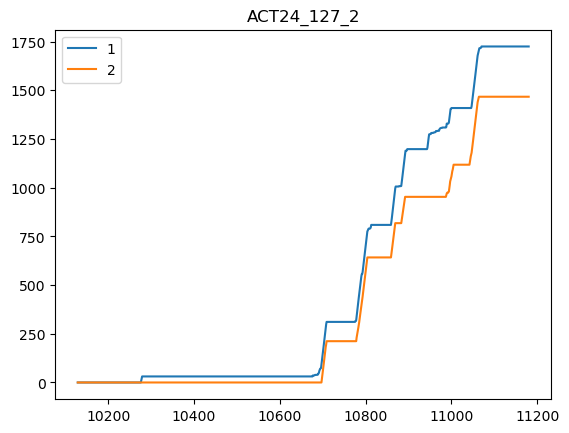

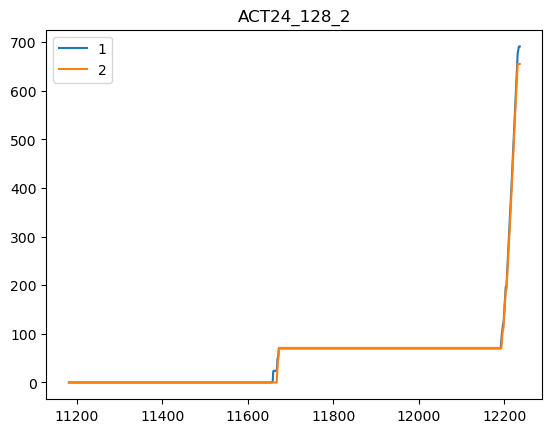

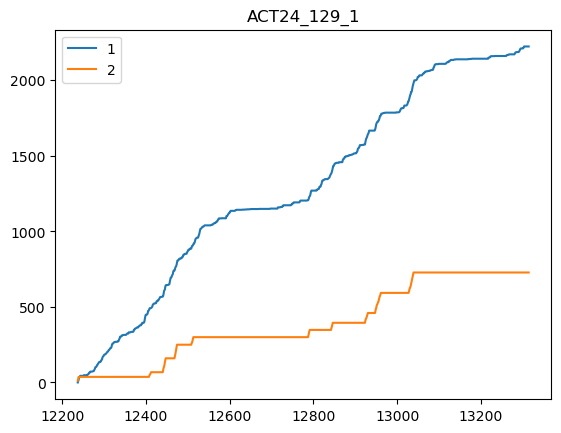

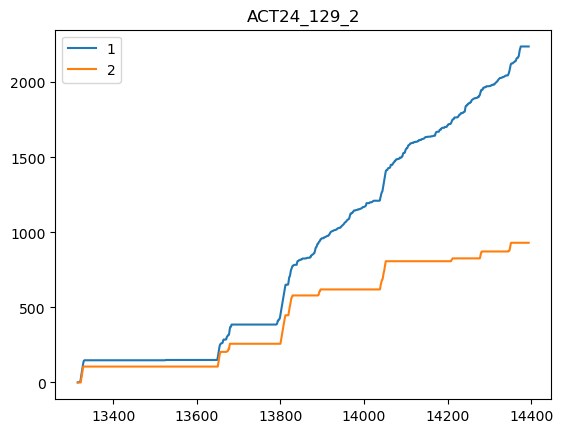

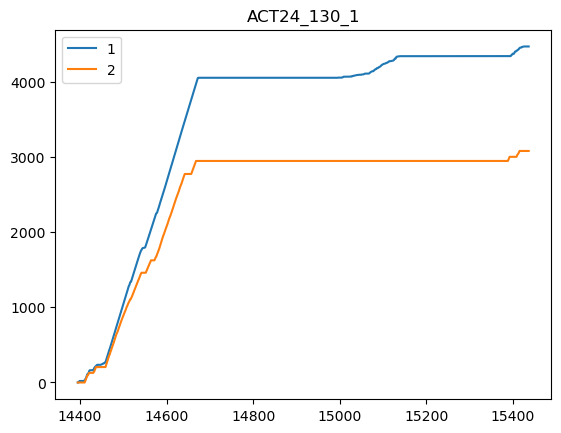

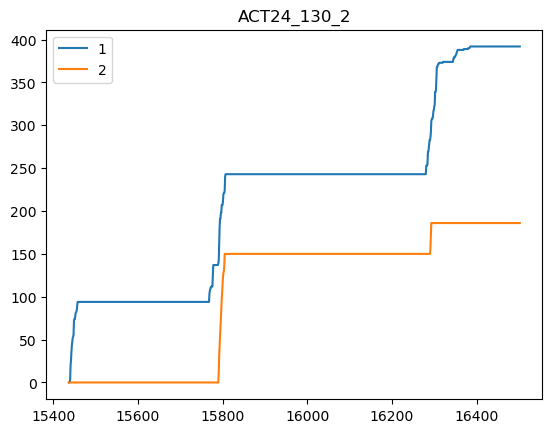

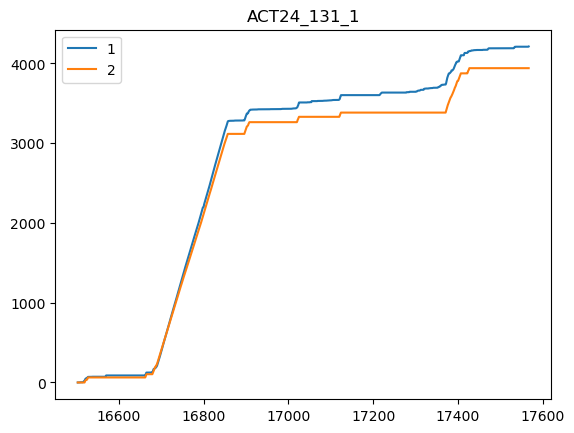

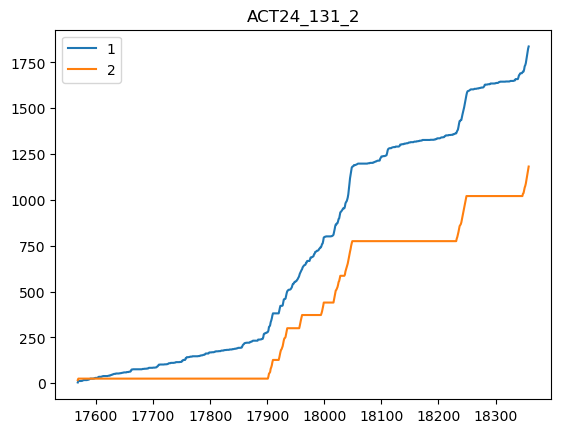

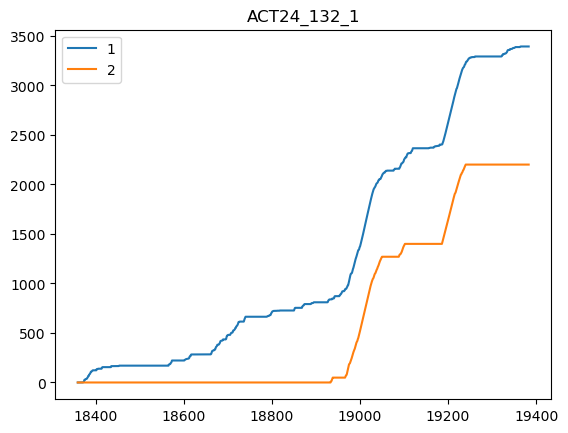

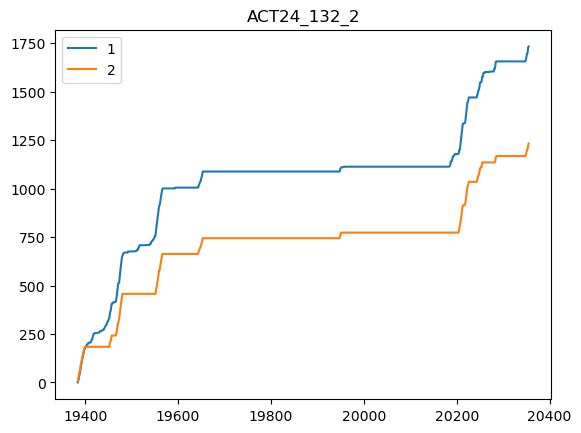

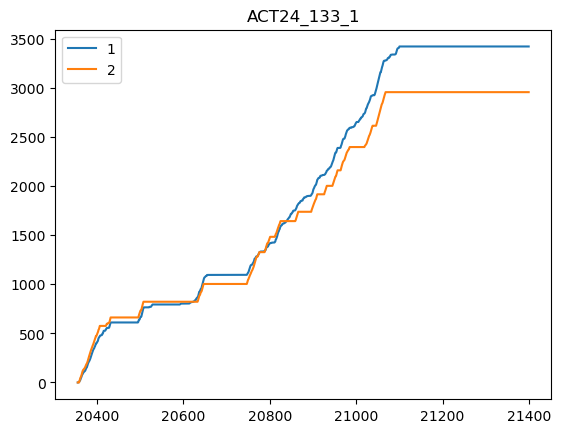

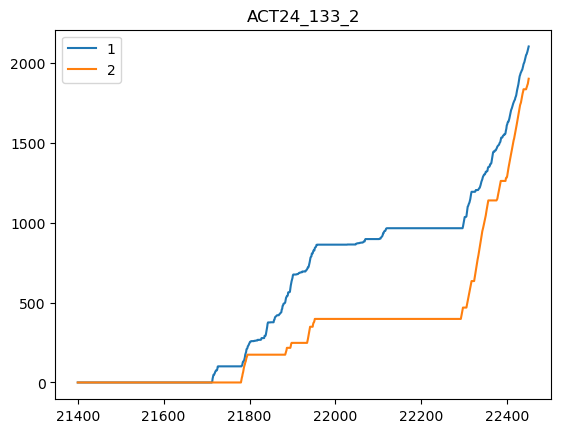

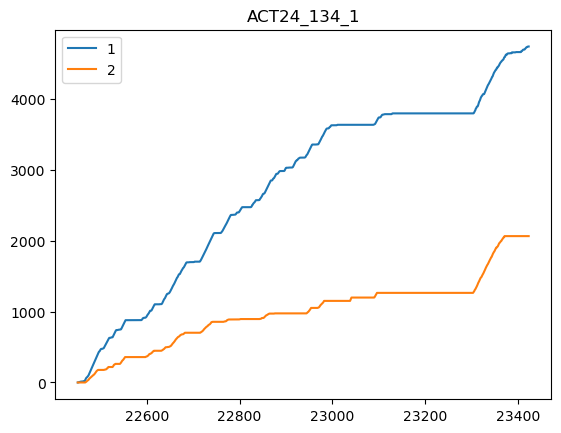

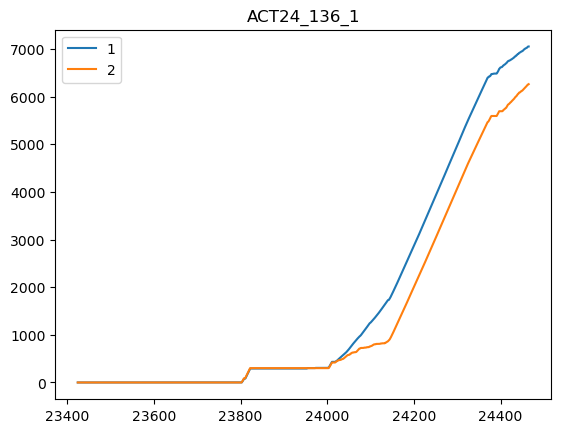

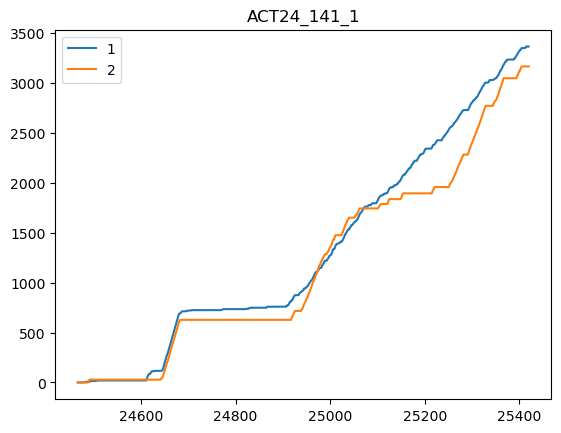

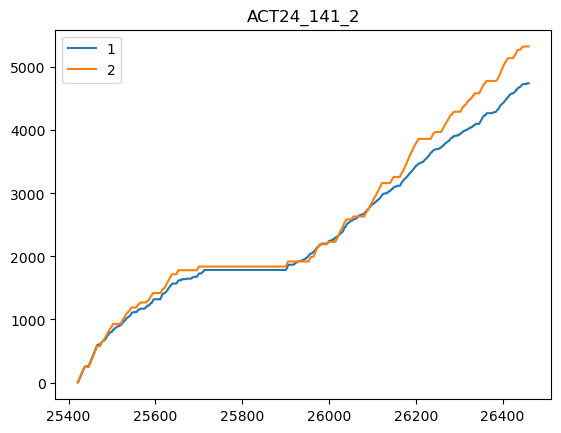

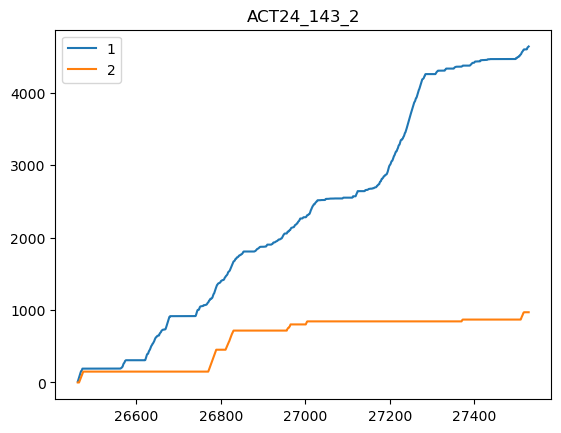

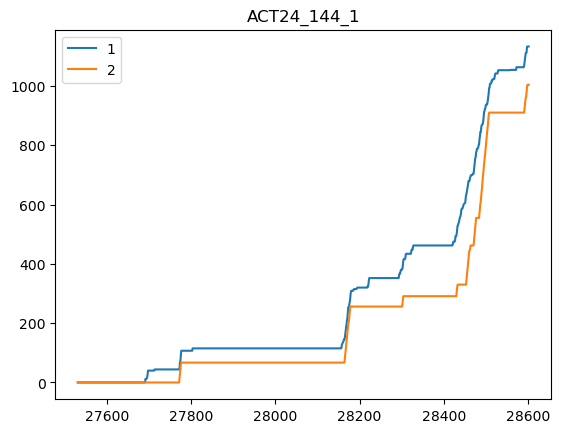

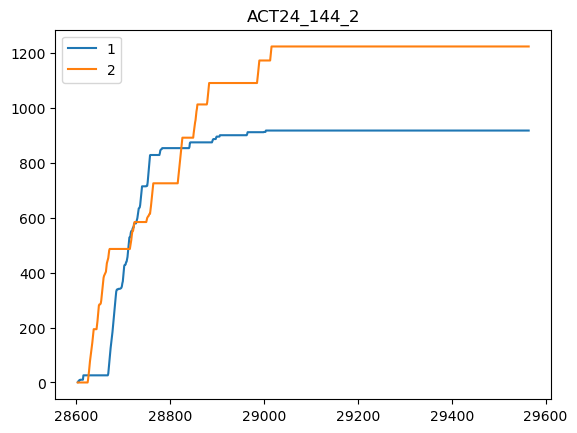

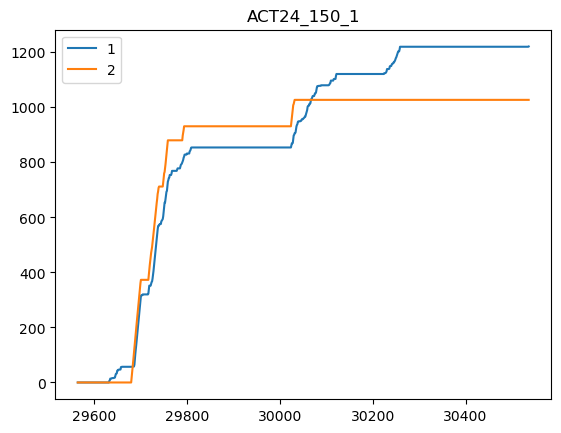

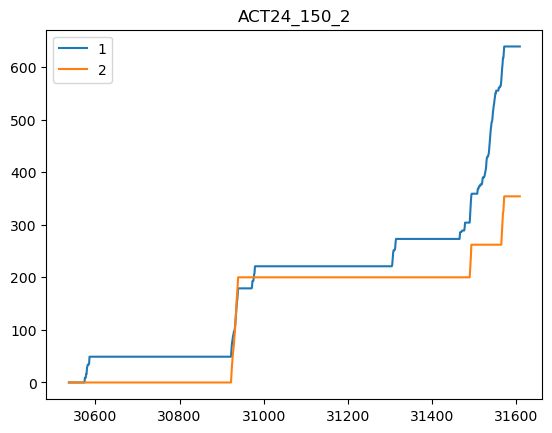

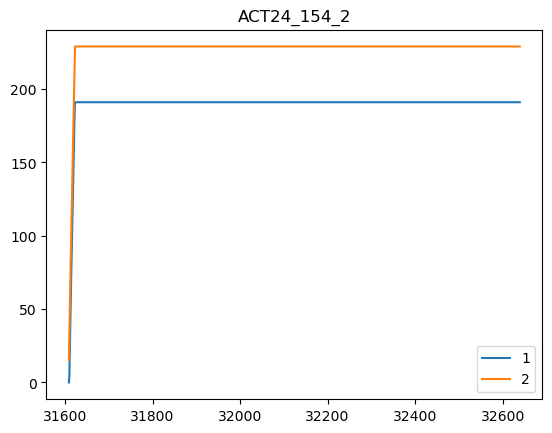

In [26]:
for g in np.unique(groups):
    preds[preds[0] == g][[1,2]].cumsum().plot.line()
    plt.title(g)
    plt.show()

Error between predicted and observed step counts, by posture:

In [27]:
Y_all = np.load(path + "Y_all.npy")
Y_all

array(['stand and move', 'walk', 'walk', ..., 'sitting', 'sitting',
       'sitting'], dtype='<U20')

In [28]:
pred = pd.concat([pd.Series(Y_all),
                  pd.Series(Y_step), pd.Series(Yp)], axis=1)
results = pred.groupby(0).sum()
results['error'] = results[1] - results[2]
results['abs_per_error'] = results['error'].abs() / results[1]
results

,1,2,error,abs_per_error
0,,,,
ascend stairs,1993,1096,897,0.450075
bike,0,0,0,NaN
descend stairs,876,927,-51,0.058219
kneeling/ squatting,525,207,318,0.605714
lying,25,0,25,1.000000
muscle strengthening,37,28,9,0.243243
other sport movement,81,10,71,0.876543
running,0,0,0,NaN
sitting,2733,1695,1038,0.379802


## Output predictions

Output predictions to .csv

In [29]:
pred_k = pd.concat([pd.Series(groups), pd.Series(T), pd.Series(Yp)], axis=1).rename(columns={0: "id_obs", 1: "time", 2: "pred_steps"})
pred_k

,id_obs,time,pred_steps
0,ACT24_116_1,2019-08-20 08:09:05,15
1,ACT24_116_1,2019-08-20 08:09:15,17
2,ACT24_116_1,2019-08-20 08:09:25,15
3,ACT24_116_1,2019-08-20 08:09:35,0
4,ACT24_116_1,2019-08-20 08:09:45,0
...,...,...,...
32635,ACT24_154_2,2020-02-23 15:55:09,0
32636,ACT24_154_2,2020-02-23 15:55:19,0
32637,ACT24_154_2,2020-02-23 15:55:29,0
32638,ACT24_154_2,2020-02-23 15:55:39,0


In [30]:
pred_k.to_csv("predicted_keadle_broad.csv")

## Test algorithm

Test on oxwalk dataset

In [31]:
path = './data/oxwalk_30hz_w10_o0/'

X_test = np.load(path + 'X.npy')
Y_step_test = np.load(path + 'Y_step.npy')
groups_test = np.load(path + 'groups.npy')
T_test = np.load(path + 'time.npy')

In [32]:
Yp_cat_test = wd.predict(X_test, groups_test)

Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount2\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 27/27 [00:04<00:00,  6.64it/s]


In [33]:
Yp_test = np.zeros_like(Yp_cat_test)
W = (Yp_cat_test == 1)

whr_walk_pred = (Yp_cat_test == 1)
Xw, Yw = X_test[whr_walk_pred], Y_step_test[whr_walk_pred]
Vw = toV(Xw, sample_rate, lowpass_hz)

Yp_test[whr_walk_pred] = batch_count_peaks_from_V(Vw, sample_rate, find_peaks_params)

In [34]:
sum(Yp_test), sum(Y_step_test)

(54986, 62841)

In [35]:
preds = pd.concat([pd.Series(groups_test), pd.Series(Y_step_test), pd.Series(Yp_test)], axis=1)
results = preds.groupby(0).sum()
results['error'] = results[1] - results[2]
results['abs_per_error'] = results['error'].abs() / results[1]
results

,1,2,error,abs_per_error
0,,,,
P01,867,780,87,0.100346
P02,477,69,408,0.855346
P03,4144,3911,233,0.056226
P04,209,0,209,1.000000
P05,528,306,222,0.420455
P06,441,521,-80,0.181406
P07,2368,2322,46,0.019426
P08,382,68,314,0.821990
P09,431,331,100,0.232019


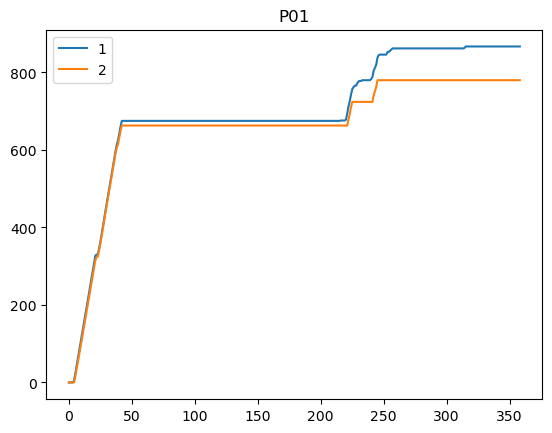

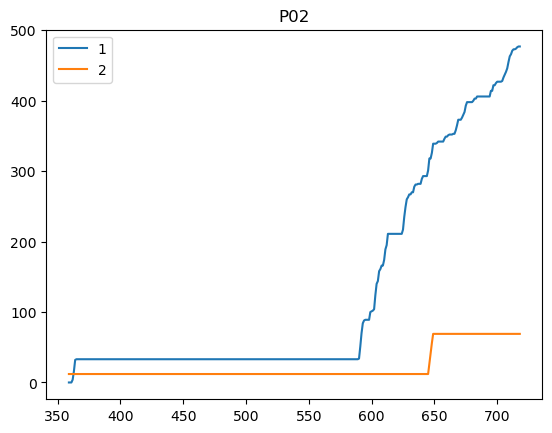

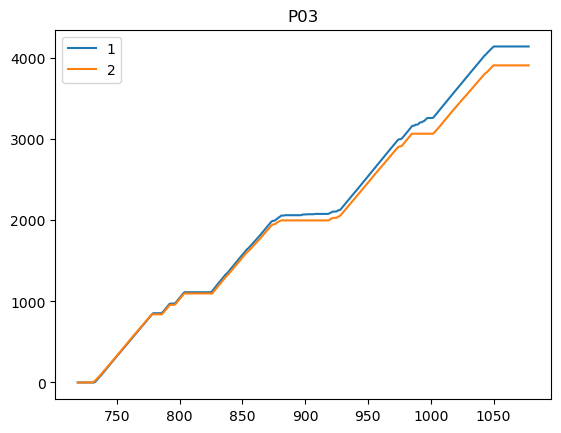

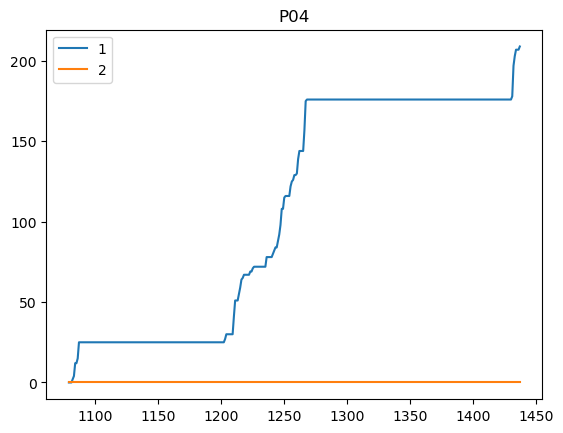

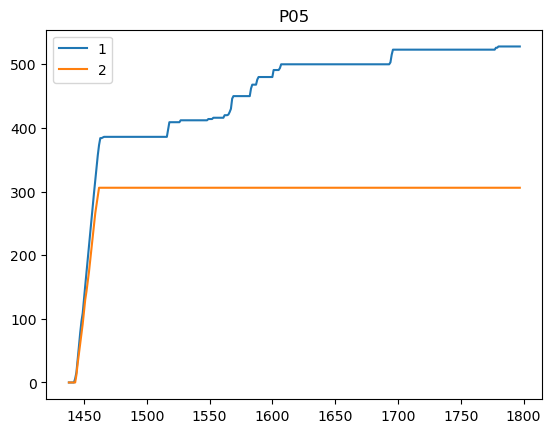

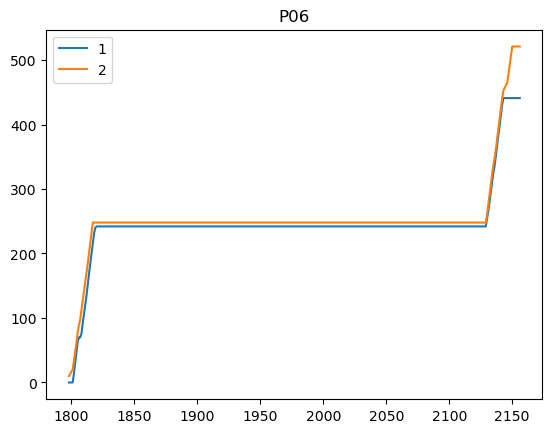

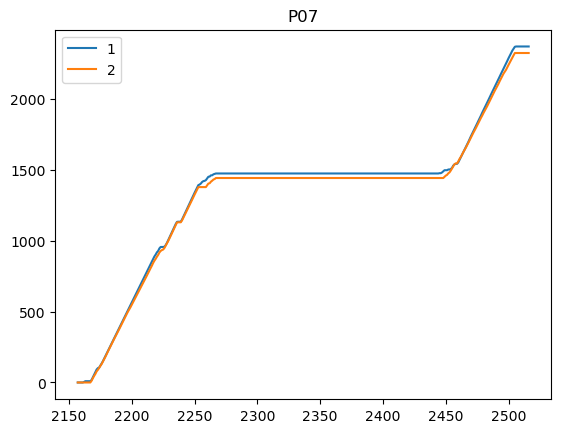

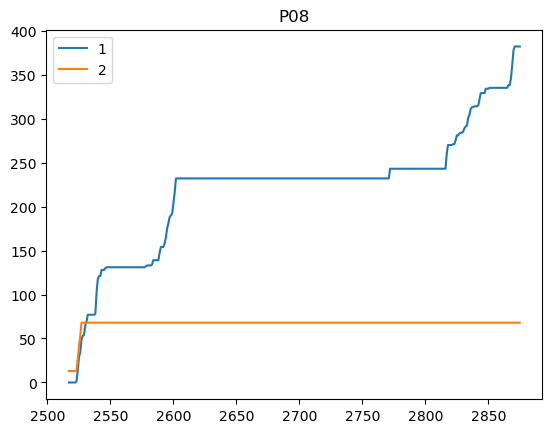

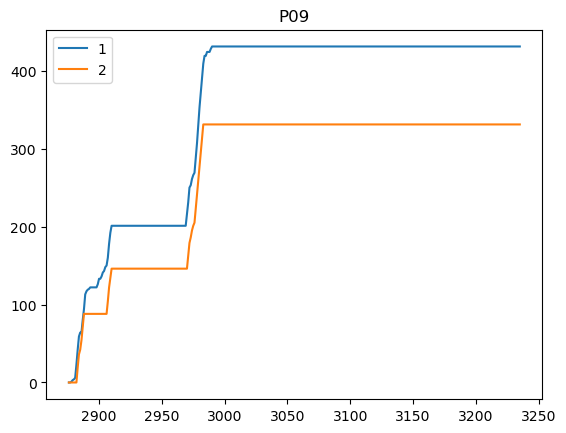

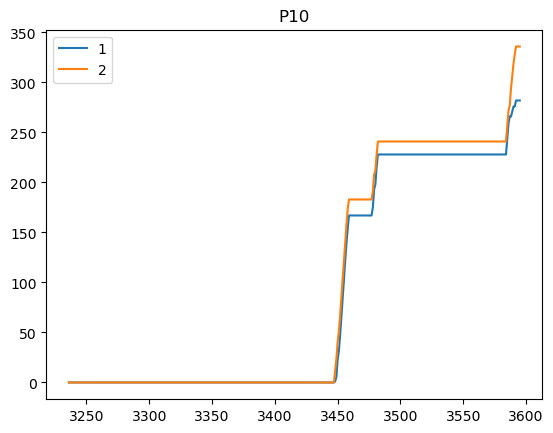

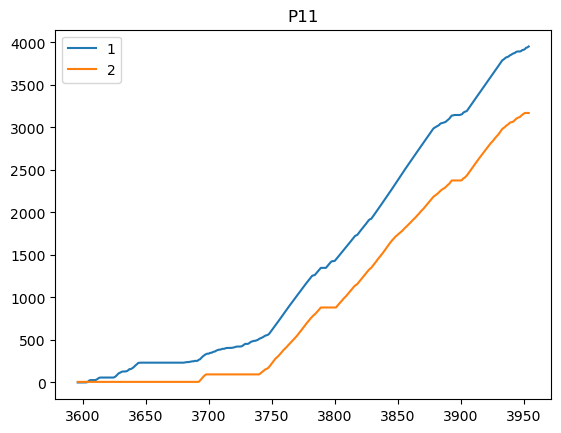

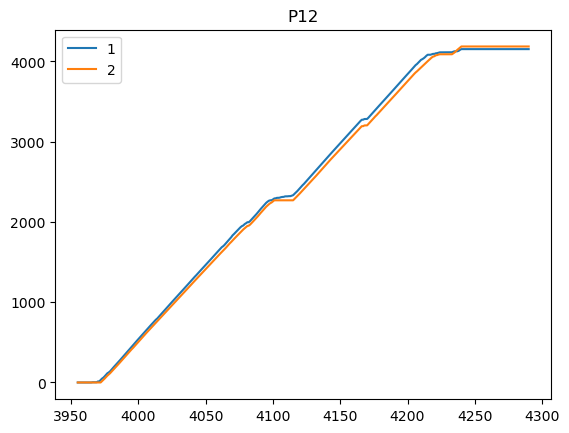

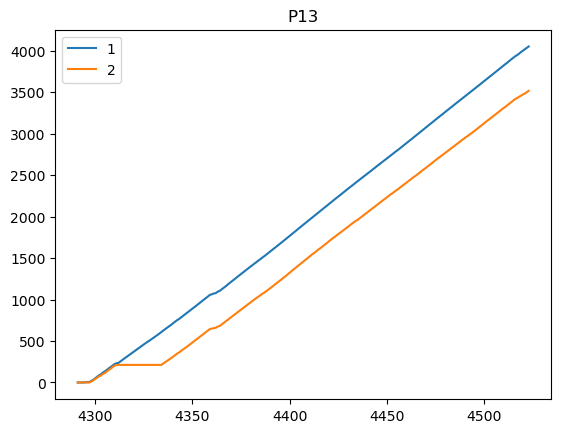

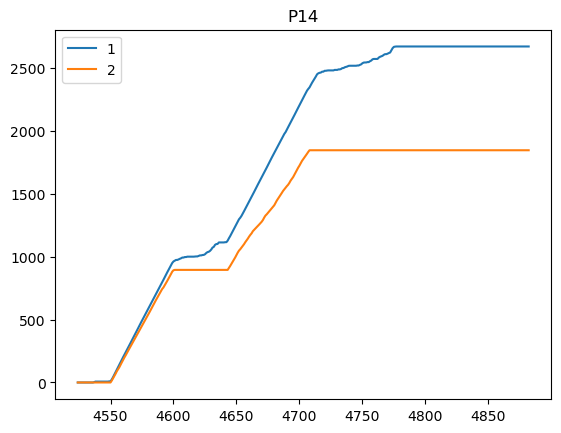

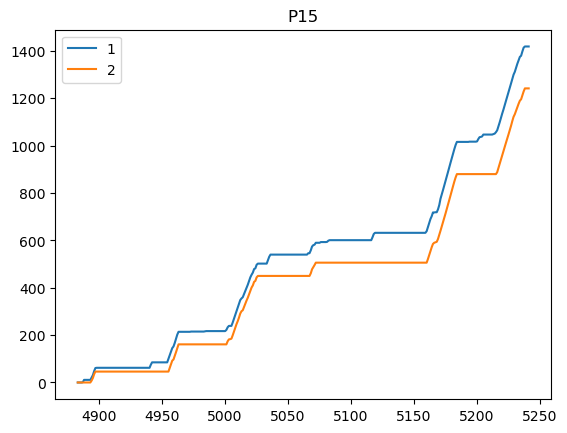

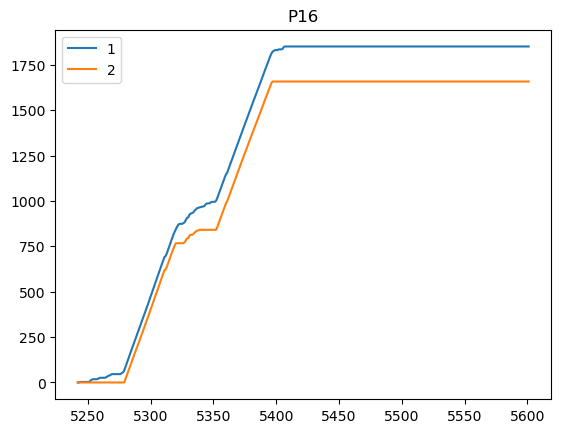

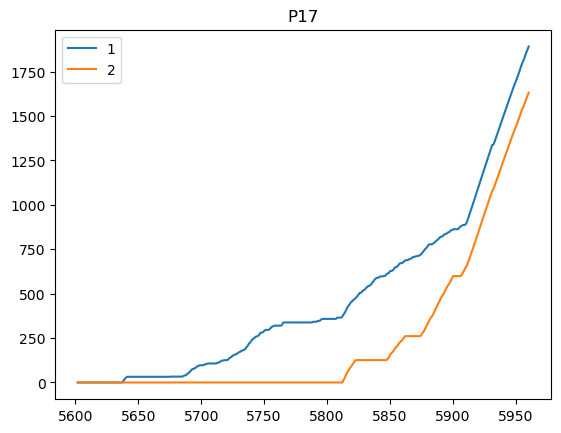

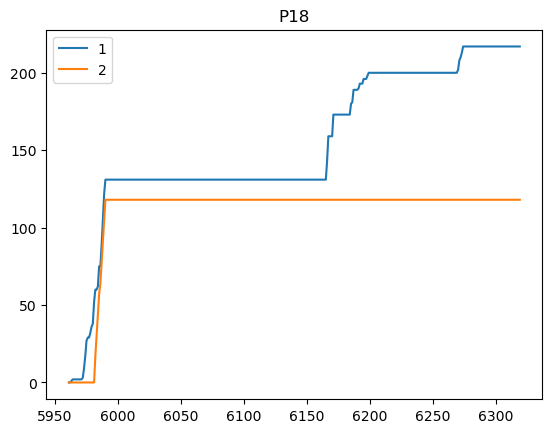

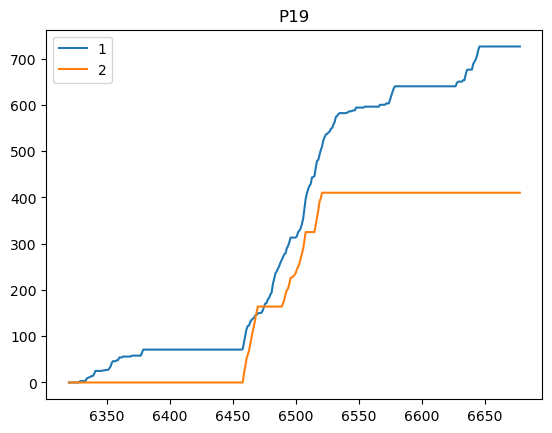

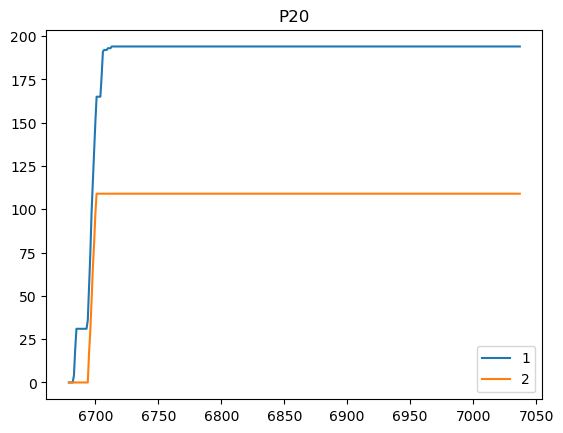

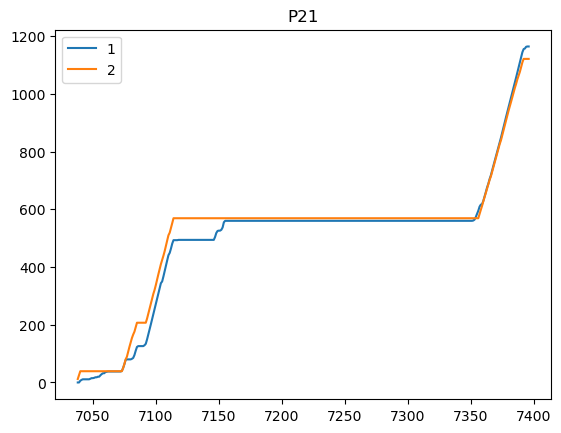

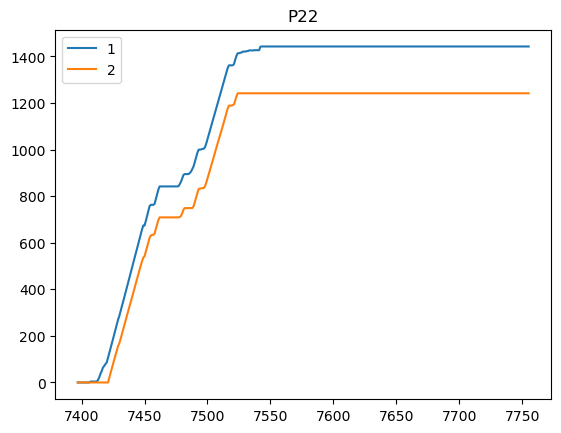

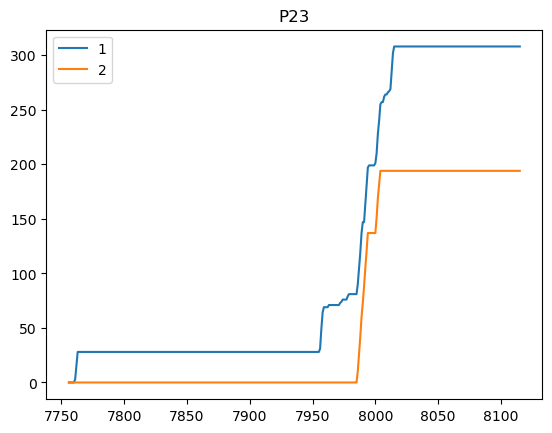

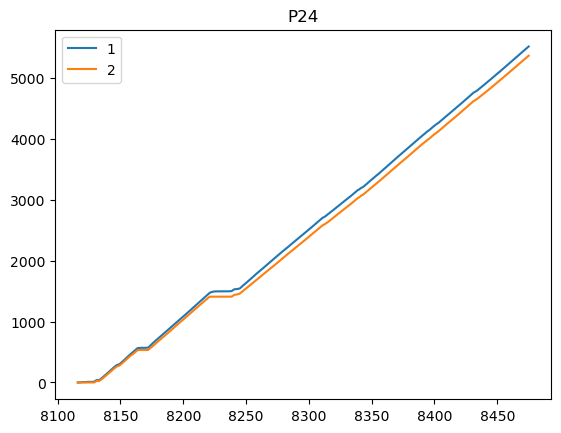

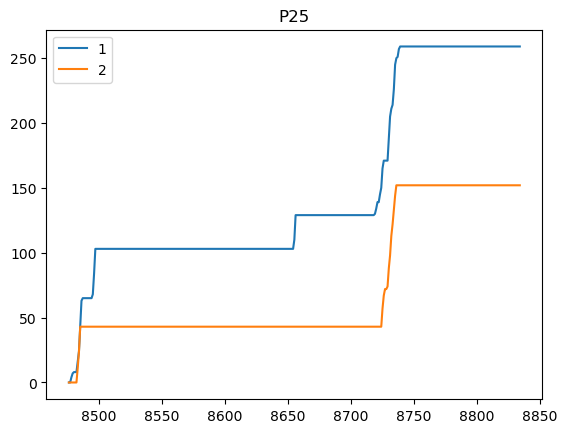

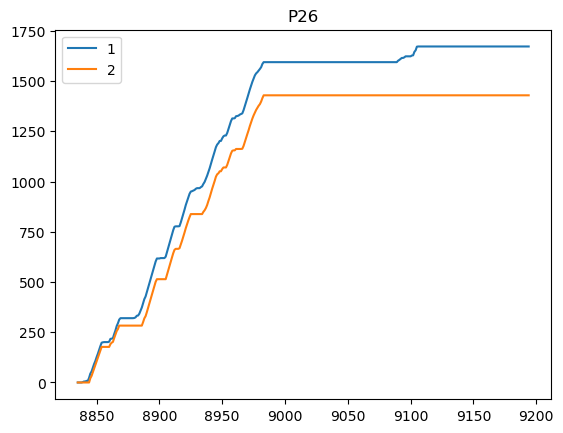

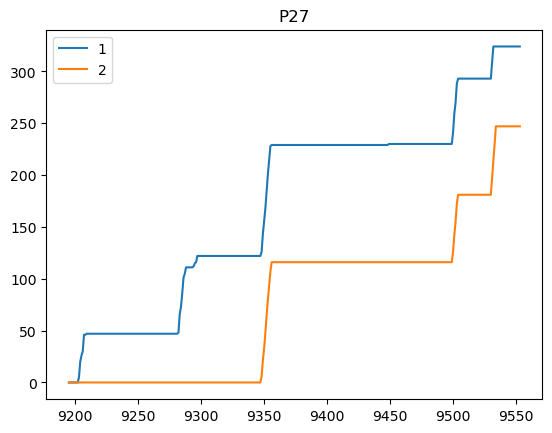

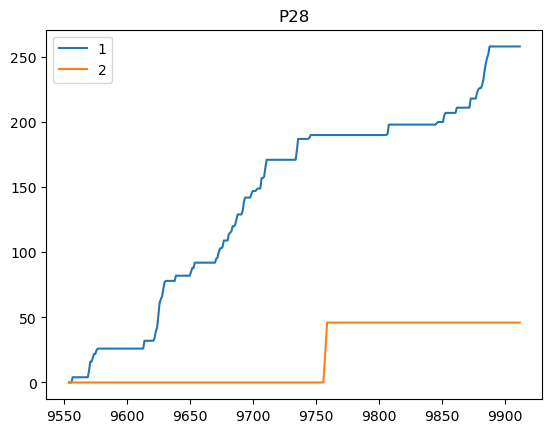

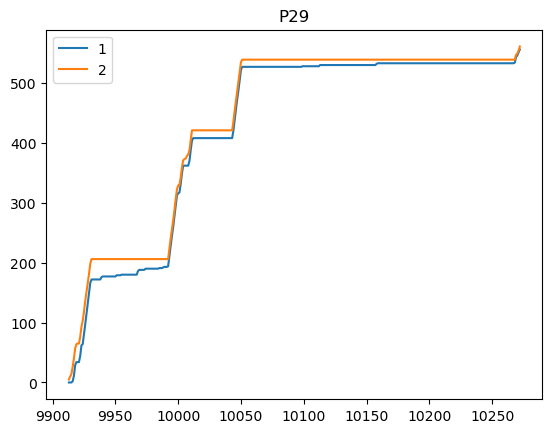

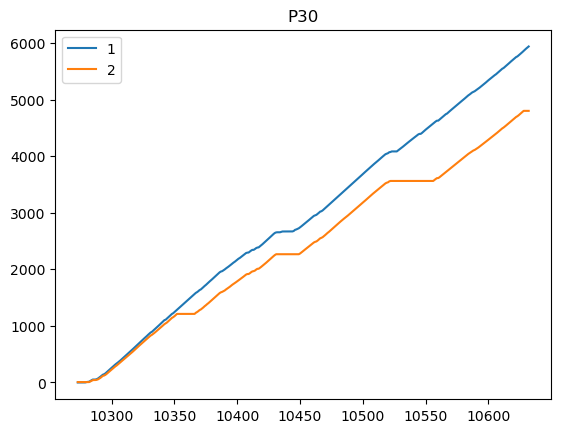

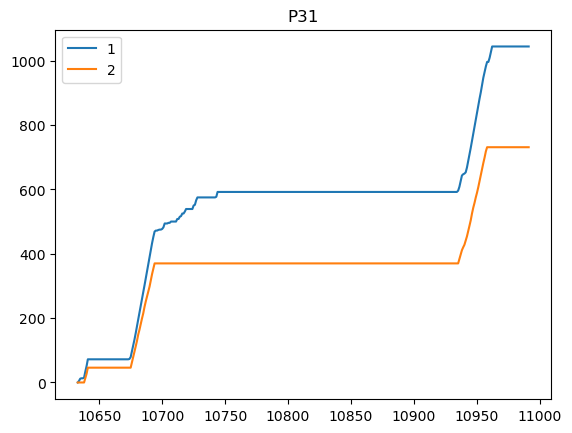

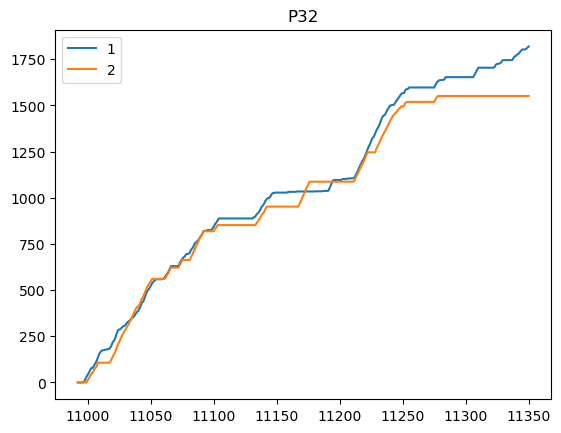

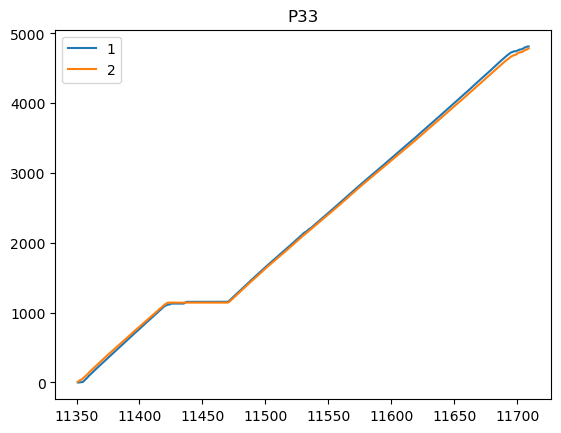

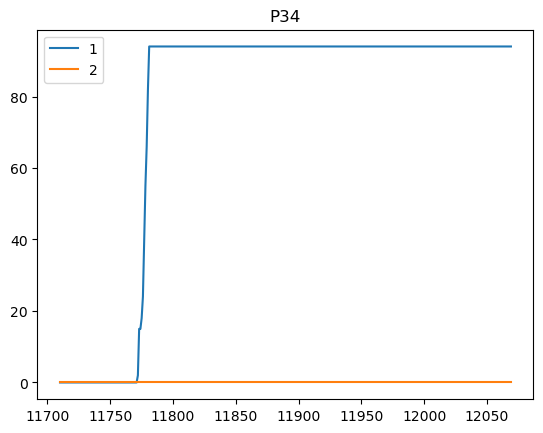

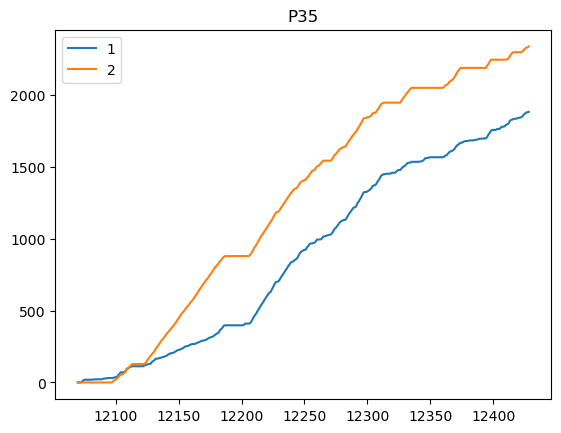

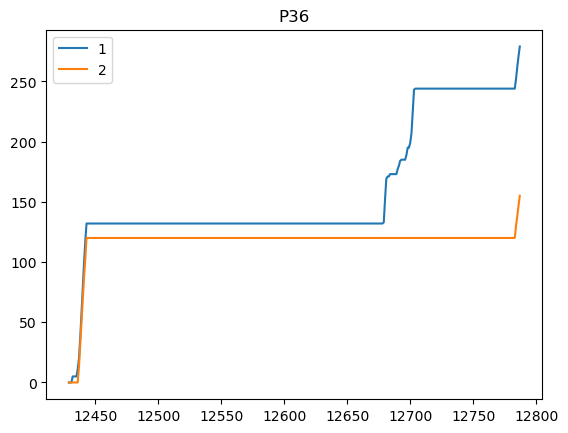

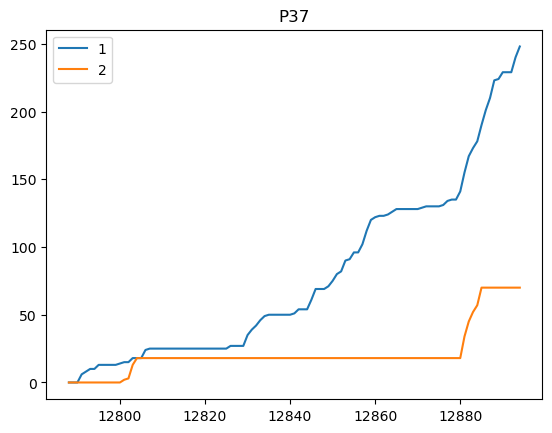

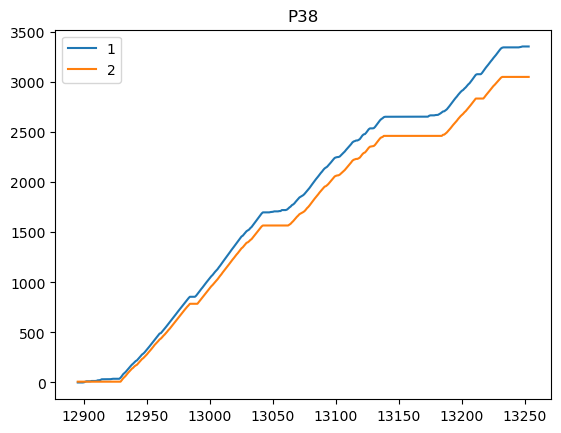

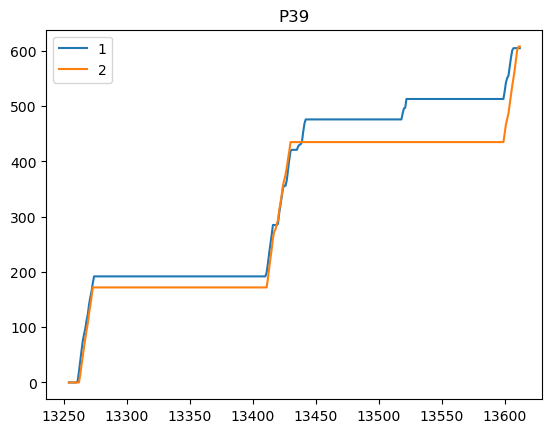

In [36]:
for g in np.unique(groups_test):
    preds[preds[0] == g][[1,2]].cumsum().plot.line()
    plt.title(g)
    plt.show()

In [37]:
pred_test = pd.concat([pd.Series(groups_test), pd.Series(T_test), pd.Series(Yp_test)], axis=1).rename(columns={0: "id_obs", 1: "time", 2: "pred_steps"})
pred_test

,id_obs,time,pred_steps
0,P01,2019-07-22 14:42:56.348,0
1,P01,2019-07-22 14:43:06.348,0
2,P01,2019-07-22 14:43:16.348,0
3,P01,2019-07-22 14:43:26.348,0
4,P01,2019-07-22 14:43:36.348,0
...,...,...,...
13608,P39,2019-07-22 14:31:52.819,16
13609,P39,2019-07-22 14:32:02.819,18
13610,P39,2019-07-22 14:32:12.819,17
13611,P39,2019-07-22 14:32:22.819,6


In [38]:
pred_test.to_csv("predicted_oxwalk_broad.csv")